In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('synthetic_fraud_risk_dataset.csv')
df.head()

,TRANSACTION_ID,CUSTOMER_ID,POLICY_EFFECTIVE_DATE,LOSS_DATE,REPORT_DATE,INSURANCE_LINE,INCIDENT_SEVERITY,PREMIUM_AMOUNT,CLAIM_AMOUNT,INCIDENT_STATE,...,AUTHORITY_CONTACTED,POLICE_REPORT_AVAILABLE,CLAIM_TO_PREMIUM_RATIO,DAYS_POLICY_TO_LOSS,DAYS_LOSS_TO_REPORT,FLAG_SHORT_WINDOW,FLAG_NIGHT_INCIDENT,FLAG_LONG_REPORT_DELAY,WEAK_SUSPECT_FLAG,FRAUD_LABEL
0,TXN000000,10000,2024-02-02,2024-03-13,2024-03-23,Property,Moderate,736.46,4866.61,NC,...,No,No,6.61,40,10,0,0,0,1,0
1,TXN000001,10001,2024-10-09,2024-10-16,2024-10-22,Health,Minor,1369.46,538.90,OH,...,Yes,Yes,0.39,7,6,1,0,0,0,0
2,TXN000002,10002,2024-08-26,2024-12-29,2025-01-13,Auto,Minor,1078.92,824.59,NY,...,No,Yes,0.76,125,15,0,0,1,0,0
3,TXN000003,10003,2024-06-09,2024-10-23,2024-11-11,Property,Major,1426.18,10085.82,NC,...,No,Yes,7.07,136,19,0,0,1,0,0
4,TXN000004,10004,2024-06-07,2024-11-08,2024-11-15,Property,Moderate,1182.55,5025.83,NC,...,No,No,4.25,154,7,0,1,0,1,0


In [3]:
"""
EDA Script for Synthetic Fraud Risk Dataset
Problem Statement: Fraud Detection
"""

import pandas as pd
import numpy as np
from datetime import datetime

# Load dataset
file_path = 'synthetic_fraud_risk_dataset.csv'
df = pd.read_csv(file_path)

# 1. Dataset Overview
print(f"Shape: {df.shape}")
print()

# 2. Missing Values Analysis
missing = df.isnull().sum()
print(pd.DataFrame({'Missing_Count': missing}))
print()

# 3. Target Variable Analysis

fraud_counts = df['FRAUD_LABEL'].value_counts()
print(f"Non-Fraudulent: {fraud_counts[0]}")
print(f"Fraudulent: {fraud_counts[1]}")
print()

# 4. Numerical Features Summary
num_cols = df.select_dtypes(include=[np.number]).columns.drop('FRAUD_LABEL')
print(df[num_cols].describe())
print()

# 5. Categorical Features Summary
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if not c.endswith('_ID')]
for col in cat_cols:
    print(f"\n{col} (Unique: {df[col].nunique()}):")
    print(df[col].value_counts().head(3))
print()

# 6. Feature Engineering Validation
df['POLICY_EFFECTIVE_DATE'] = pd.to_datetime(df['POLICY_EFFECTIVE_DATE'])
df['LOSS_DATE'] = pd.to_datetime(df['LOSS_DATE'])
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])
# validate days
df['calc_policy_to_loss'] = (df['LOSS_DATE'] - df['POLICY_EFFECTIVE_DATE']).dt.days
df['calc_loss_to_report'] = (df['REPORT_DATE'] - df['LOSS_DATE']).dt.days
print("Policy to Loss match:", (df['DAYS_POLICY_TO_LOSS'] == df['calc_policy_to_loss']).all())
print("Loss to Report match:", (df['DAYS_LOSS_TO_REPORT'] == df['calc_loss_to_report']).all())
print()

# 7. Risk Flags by Fraud Label
flags = ['FLAG_SHORT_WINDOW','FLAG_NIGHT_INCIDENT','FLAG_LONG_REPORT_DELAY','WEAK_SUSPECT_FLAG']
for f in flags:
    dist = pd.crosstab(df[f], df['FRAUD_LABEL'], normalize='columns') * 100
    print(f, dist.loc[1].to_dict())
print()

# 8. Correlation Analysis
corrs = df[num_cols.tolist()+['FRAUD_LABEL']].corr()['FRAUD_LABEL'].drop('FRAUD_LABEL').abs().sort_values(ascending=False)
print(corrs.head(10))
print()

# 9. High-Risk Patterns
threshold = df['CLAIM_TO_PREMIUM_RATIO'].quantile(0.95)
print(f"95th percentile ratio threshold: {threshold:.2f}")
high_ratio = df[df['CLAIM_TO_PREMIUM_RATIO'] > threshold]
print("Fraud rate among high ratio:", high_ratio['FRAUD_LABEL'].mean())
print()



Shape: (5000, 30)

                         Missing_Count
TRANSACTION_ID                       0
CUSTOMER_ID                          0
POLICY_EFFECTIVE_DATE                0
LOSS_DATE                            0
REPORT_DATE                          0
INSURANCE_LINE                       0
INCIDENT_SEVERITY                    0
PREMIUM_AMOUNT                       0
CLAIM_AMOUNT                         0
INCIDENT_STATE                       0
INCIDENT_HOUR                        0
AGE                                  0
TENURE_DAYS                          0
MARITAL_STATUS                       0
NO_FAMILY_MEMBERS                    0
EMPLOYMENT_STATUS                    0
EDUCATION_LEVEL                      0
HOUSE_TYPE                           0
SOCIAL_CLASS                         0
RISK_SEGMENTATION                    0
AUTHORITY_CONTACTED                  0
POLICE_REPORT_AVAILABLE              0
CLAIM_TO_PREMIUM_RATIO               0
DAYS_POLICY_TO_LOSS                  0
DAYS_L

In [4]:
import seaborn as sns

num_cols = [
    "PREMIUM_AMOUNT",
    "CLAIM_AMOUNT",
    "CLAIM_TO_PREMIUM_RATIO",
    "DAYS_POLICY_TO_LOSS",
    "DAYS_LOSS_TO_REPORT"
]

flag_cols = [
    "FLAG_SHORT_WINDOW",
    "FLAG_NIGHT_INCIDENT",
    "FLAG_LONG_REPORT_DELAY",
    "WEAK_SUSPECT_FLAG"
]

target_col = "FRAUD_LABEL"

# Keep only columns that exist (in case of schema changes)
num_cols = [c for c in num_cols if c in df.columns]
flag_cols = [c for c in flag_cols if c in df.columns]


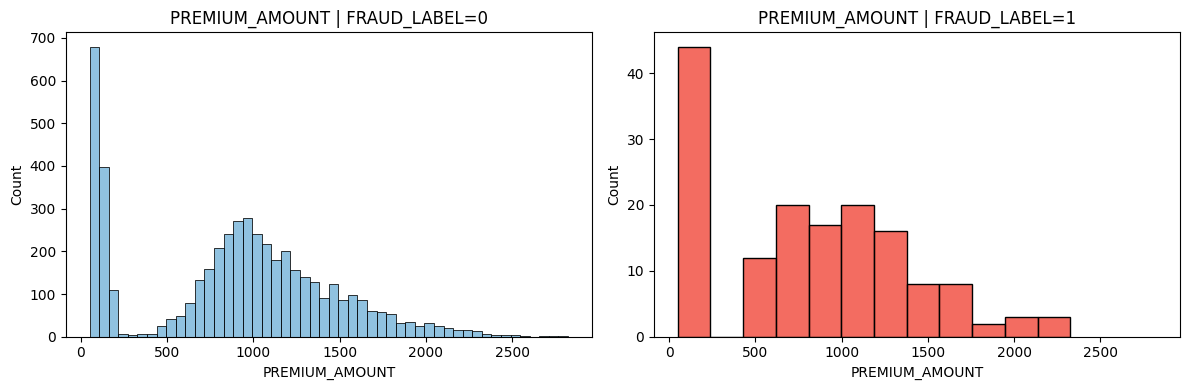

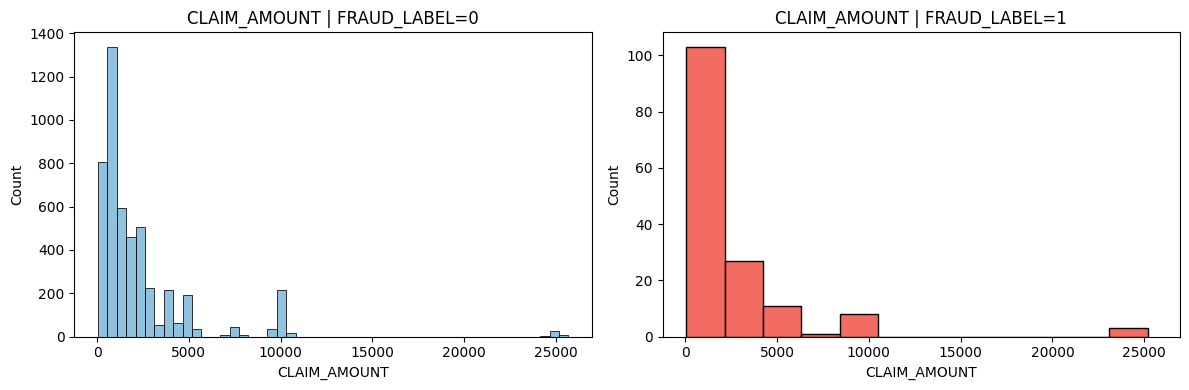

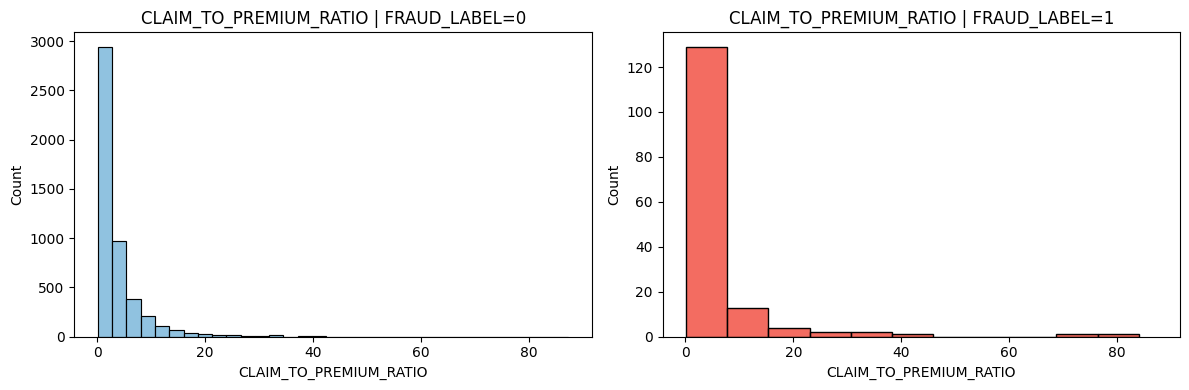

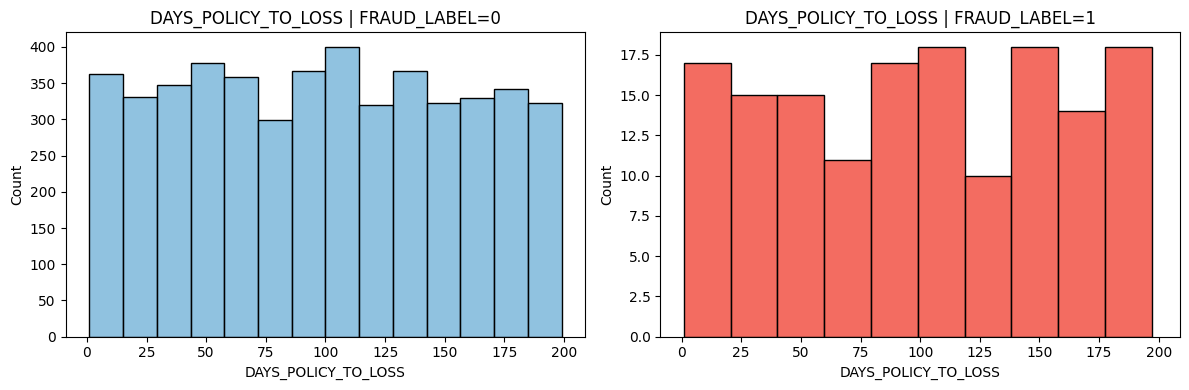

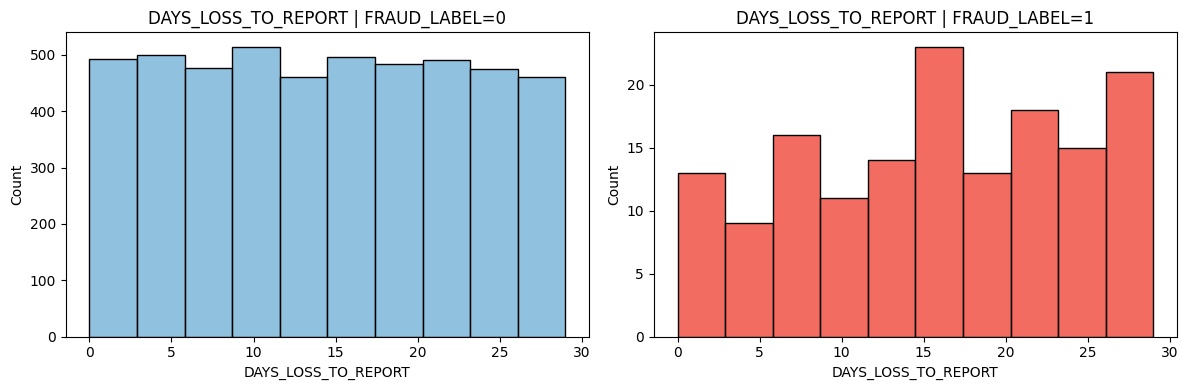

In [5]:
# Numeric distributions, log-safe bins, by class
import math

def smart_bins(series, max_bins=50):
    s = series.dropna()
    if s.empty:
        return 10
    unique = s.nunique()
    bins = min(max_bins, max(10, int(np.sqrt(unique))))
    return bins

palette = {0: "#6baed6", 1: "#ef3b2c"}  # non-fraud vs fraud

for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    for i, label in enumerate([0, 1]):
        subset = df[df[target_col] == label][col]
        bins = smart_bins(subset)
        sns.histplot(subset, bins=bins, kde=False, color=palette[label], ax=ax[i])
        ax[i].set_title(f"{col} | FRAUD_LABEL={label}")
        ax[i].set_xlabel(col)
        ax[i].set_ylabel("Count")
    plt.tight_layout()
    plt.show()


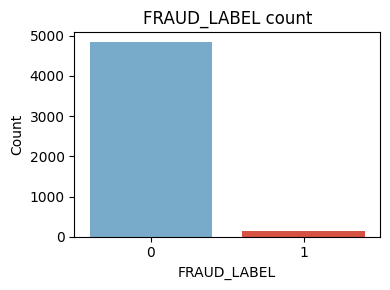

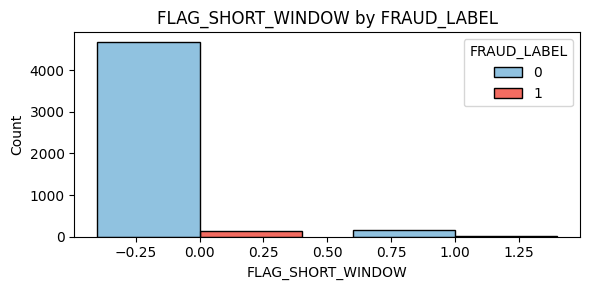

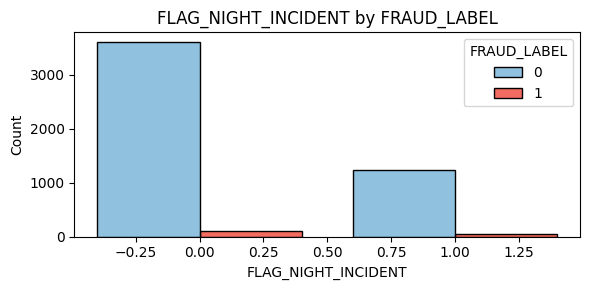

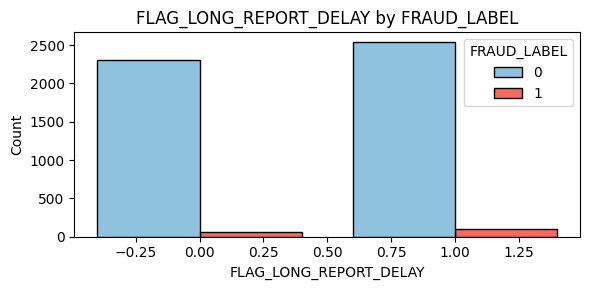

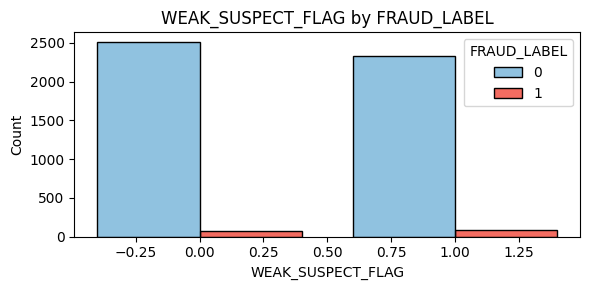

In [6]:
# Target class balance
plt.figure(figsize=(4,3))
sns.countplot(x=target_col, data=df, palette=[palette[0], palette[1]])
plt.title("FRAUD_LABEL count")
plt.xlabel("FRAUD_LABEL")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Binary flag distributions by class
for col in flag_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(
        data=df,
        x=col,
        hue=target_col,
        multiple="dodge",
        discrete=True,
        shrink=0.8,
        palette=[palette[0], palette[1]]
    )
    plt.title(f"{col} by FRAUD_LABEL")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


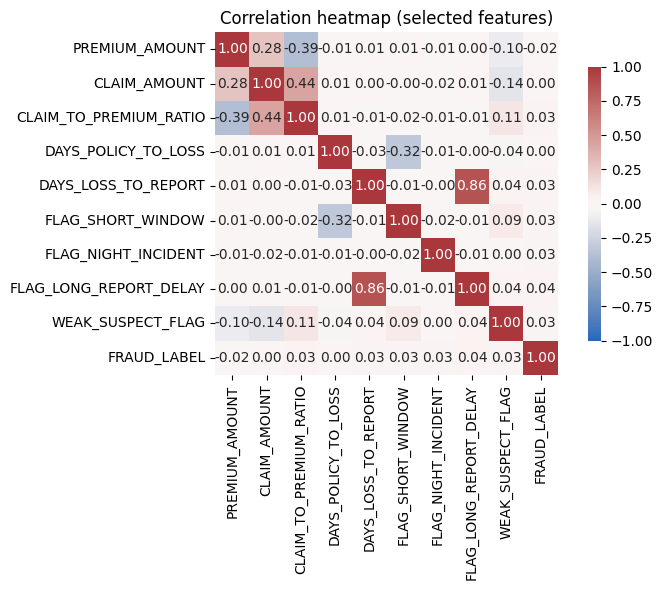

In [7]:
# Choose numeric modeling-relevant columns (exclude IDs/dates)
heatmap_cols = list(dict.fromkeys(num_cols + flag_cols + [target_col]))
heatmap_df = df[heatmap_cols].copy()

# Optionally winsorize extreme values for clearer correlations
for c in num_cols:
    if c in heatmap_df.columns:
        lower, upper = heatmap_df[c].quantile([0.01, 0.99])
        heatmap_df[c] = heatmap_df[c].clip(lower, upper)

corr = heatmap_df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap="vlag",
    annot=True, fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation heatmap (selected features)")
plt.tight_layout()
plt.show()


In [10]:
"""
Logistic Regression Model for Fraud Detection
"""

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,average_precision_score

df['POLICY_EFFECTIVE_DATE'] = pd.to_datetime(df['POLICY_EFFECTIVE_DATE'])
df['LOSS_DATE'] = pd.to_datetime(df['LOSS_DATE'])
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])

# Calculate intervals
df['DAYS_POLICY_TO_LOSS'] = (df['LOSS_DATE'] - df['POLICY_EFFECTIVE_DATE']).dt.days
df['DAYS_LOSS_TO_REPORT'] = (df['REPORT_DATE'] - df['LOSS_DATE']).dt.days

# Flags based on domain thresholds
df['FLAG_SHORT_WINDOW'] = (df['DAYS_POLICY_TO_LOSS'] < 30).astype(int)
df['FLAG_LONG_REPORT_DELAY'] = (df['DAYS_LOSS_TO_REPORT'] > 21).astype(int)
df['FLAG_NIGHT_INCIDENT'] = df['INCIDENT_HOUR'].apply(lambda x: 1 if x < 6 or x > 22 else 0)
df['WEAK_SUSPECT_FLAG'] = df['WEAK_SUSPECT_FLAG']

# 3. Define features and target
target = 'FRAUD_LABEL'
# Select raw numerical, flags, and categorical
raw_num = ['PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CLAIM_TO_PREMIUM_RATIO',
           'DAYS_POLICY_TO_LOSS', 'DAYS_LOSS_TO_REPORT']
flags = ['FLAG_SHORT_WINDOW', 'FLAG_LONG_REPORT_DELAY', 'FLAG_NIGHT_INCIDENT', 'WEAK_SUSPECT_FLAG']
cat_cols = ['INSURANCE_LINE', 'INCIDENT_SEVERITY', 'RISK_SEGMENTATION']

features = raw_num + flags + cat_cols
X = df[features]
y = df[target]

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, raw_num),
    ('cat', categorical_transformer, cat_cols)
], remainder='passthrough')

# 6. Create modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# 7. Train the model
model.fit(X_train, y_train)

# 8. Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")



Confusion Matrix:
[[581 388]
 [ 17  14]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9716    0.5996    0.7415       969
           1     0.0348    0.4516    0.0647        31

    accuracy                         0.5950      1000
   macro avg     0.5032    0.5256    0.4031      1000
weighted avg     0.9425    0.5950    0.7206      1000


ROC AUC Score: 0.5438


In [11]:
pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(solver="saga", max_iter=5000, random_state=42))
])

param_distributions = {
    "clf__C": np.logspace(-4, 4, 50),               # wide range of regularization
    "clf__penalty": ["l1", "l2", "elasticnet"],
    "clf__l1_ratio": np.linspace(0, 1, 11),         # only used with elasticnet (ignored otherwise)
    "clf__class_weight": [None, "balanced"]
}

# ---------- RandomizedSearchCV ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="average_precision",   # PR-AUC (good for imbalanced problems)
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    refit=True
)

print("Starting hyperparameter search (this may take a while)...")
search.fit(X_train, y_train)

print("\nBest parameters found:")
print(search.best_params_)
print("Best cross-val score (avg precision):", search.best_score_)

# ---------- Evaluate on test set ----------
best_pipe = search.best_estimator_
y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

print("\nTest set metrics:")
print("ROC AUC:", round(roc_auc_score(y_test, y_test_proba), 4) if len(set(y_test))>1 else "NA")
print("PR AUC :", round(average_precision_score(y_test, y_test_proba), 4) if len(set(y_test))>1 else "NA")
print(classification_report(y_test, y_test_pred, digits=4))

Starting hyperparameter search (this may take a while)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best parameters found:
{'clf__penalty': 'l1', 'clf__l1_ratio': np.float64(0.30000000000000004), 'clf__class_weight': None, 'clf__C': np.float64(109.85411419875572)}
Best cross-val score (avg precision): 0.04817485580147605

Test set metrics:
ROC AUC: 0.5486
PR AUC : 0.04
              precision    recall  f1-score   support

           0     0.9690    1.0000    0.9843       969
           1     0.0000    0.0000    0.0000        31

    accuracy                         0.9690      1000
   macro avg     0.4845    0.5000    0.4921      1000
weighted avg     0.9390    0.9690    0.9537      1000



In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Load and preprocess
df = pd.read_csv('synthetic_fraud_risk_dataset.csv', parse_dates=[
    'POLICY_EFFECTIVE_DATE','LOSS_DATE','REPORT_DATE'
])
# Recompute intervals and flags
df['DAYS_POLICY_TO_LOSS'] = (df.LOSS_DATE - df.POLICY_EFFECTIVE_DATE).dt.days
df['DAYS_LOSS_TO_REPORT'] = (df.REPORT_DATE - df.LOSS_DATE).dt.days
df['FLAG_SHORT_WINDOW'] = (df.DAYS_POLICY_TO_LOSS < 30).astype(int)
df['FLAG_LONG_REPORT_DELAY'] = (df.DAYS_LOSS_TO_REPORT > 21).astype(int)
df['FLAG_NIGHT_INCIDENT'] = df.INCIDENT_HOUR.apply(lambda x: 1 if x<6 or x>22 else 0)

features = [
    'PREMIUM_AMOUNT','CLAIM_AMOUNT','CLAIM_TO_PREMIUM_RATIO',
    'DAYS_POLICY_TO_LOSS','DAYS_LOSS_TO_REPORT',
    'FLAG_SHORT_WINDOW','FLAG_LONG_REPORT_DELAY','FLAG_NIGHT_INCIDENT','WEAK_SUSPECT_FLAG',
    'INSURANCE_LINE','INCIDENT_SEVERITY','RISK_SEGMENTATION'
]
X = df[features]
y = df.FRAUD_LABEL

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Preprocessing
numeric_features = [
    'PREMIUM_AMOUNT','CLAIM_AMOUNT','CLAIM_TO_PREMIUM_RATIO',
    'DAYS_POLICY_TO_LOSS','DAYS_LOSS_TO_REPORT'
]
categorical_features = ['INSURANCE_LINE','INCIDENT_SEVERITY','RISK_SEGMENTATION']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features),
], remainder='passthrough')

# 4. Pipeline with Random Forest
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        max_depth=8,
        random_state=42
    ))
])

# 5. Train
pipeline.fit(X_train, y_train)

# 6. Evaluate
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


Confusion Matrix:
[[963   6]
 [ 31   0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9688    0.9938    0.9812       969
           1     0.0000    0.0000    0.0000        31

    accuracy                         0.9630      1000
   macro avg     0.4844    0.4969    0.4906      1000
weighted avg     0.9388    0.9630    0.9507      1000


ROC AUC Score: 0.5304
